# **EDA para Radiografías de Tórax**
# ITESM - MNA V

## Proyecto Integrador - TC5035.10

## Profesora: Dra. Grettel Barceló Alonso


### Equipo 19

Héctor Segura Quintanilla (A01154108)

Julio César García Escoto (A01795050)

Francisco Medellín Zertuche (A01794044)


# Introducción

El presente análisis exploratorio de datos (EDA) se centra en un conjunto de radiografías clasificado en diferentes categorías diagnósticas. A diferencia de un EDA convencional basado en información tabular, este estudio adopta un enfoque orientado a imágenes, lo cual implica atender no solo la distribución de clases, sino también las propiedades de los archivos visuales. Para ello, se revisaron aspectos como la composición del dataset por clase, la resolución de las imágenes, la relación de aspecto y la variabilidad en intensidades. Este enfoque permite identificar patrones de heterogeneidad en el tamaño y calidad de las radiografías, así como posibles sesgos de clase que podrían influir en el entrenamiento de modelos de aprendizaje profundo.

De esta manera, nos enfocamos en comprender la estructura y calidad del dataset, garantizando que los procesos posteriores de preprocesamiento, estandarización y modelado partan de un diagnóstico basado en el escrutinio de los datos disponibles.

# 1. Setup inicial

In [1]:
!pip install ImageHash

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from collections import Counter
from tqdm import tqdm

import cv2
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import imagehash


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.1 MB/s eta 0:00:00


# 2. Configuración del dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 2.1. Ruta al dataset (usa tu ruta local)
data_dir = "/content/drive/MyDrive/CARDIOS - PROYECTO INTEGRADOR/Datos"


class_names = sorted(os.listdir(data_dir))
print("Clases encontradas:", class_names)

Clases encontradas: ['ASD', 'Normal', 'PDA', 'VSD']


In [4]:
# 2.2. Obtener imágenes por clase
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_file))
        labels.append(class_name)

df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

In [ ]:
# Clases
df.label.unique()

array(['ASD', 'Normal', 'PDA', 'VSD'], dtype=object)

# 3. Distribución de clases

In [ ]:
# Conteo de clases
class_counts = df['label'].value_counts()

print("Conteo de clases:")
print(class_counts)

Conteo de clases:
label
PDA       216
VSD       210
Normal    208
ASD       194
Name: count, dtype: int64


/tmp/ipython-input-1793240838.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues", edgecolor="black")


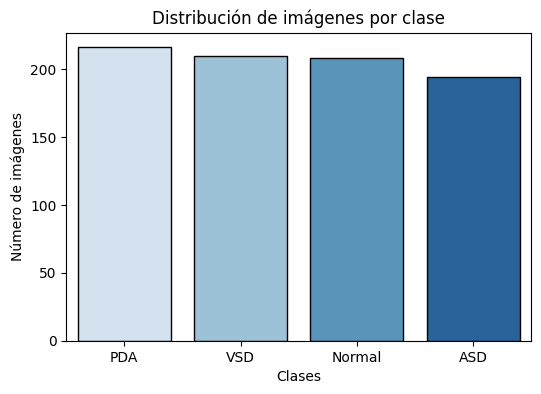

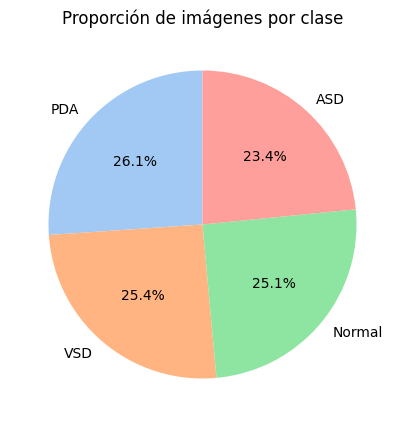

In [ ]:
# Distribución de clases y graficos

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Blues", edgecolor="black")
plt.title("Distribución de imágenes por clase")
plt.xlabel("Clases")
plt.ylabel("Número de imágenes")
plt.show()

# Gráfico de pastel para proporciones
plt.figure(figsize=(5,5))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Proporción de imágenes por clase")
plt.show()

Si bien no se observa un desbalanceo de clases severo, dado el contexto médico del proyecto, las implicaciones de desvíos ligeros pueden llegar a tener un impacto significativo en el desempeño del modelo, y en consecuencia, en la vida de los pacientes. Para tratar con el desbalanceo de clases cuando este sea franco, se considera las siguientes alternativas:

* **Aumento de datos** (Data Augmentation): aplicar transformaciones específicas (rotaciones, cambios de brillo, escalados, recortes controlados) para incrementar artificialmente las muestras de la clase con menor representación (ASD).
* **Reponderación de clases**: usar class weights en la función de pérdida (por ejemplo en cross-entropy) para penalizar más los errores en clases con menos ejemplos.
* **Submuestreo o sobremuestreo**: equilibrar el dataset reduciendo ejemplos de clases mayoritarias o incrementando los de las minoritarias mediante técnicas como SMOTE adaptado a imágenes.
* **Enfoques de evaluación balanceada**: utilizar métricas como macro F1-score o balanced accuracy que evitan que una ligera diferencia de tamaño de clase influya desproporcionadamente en el resultado global.
Recolección adicional de datos: si es posible, obtener más radiografías de la clase ASD para mejorar la representatividad del conjunto.

# 4. Visualización de imágenes por clase

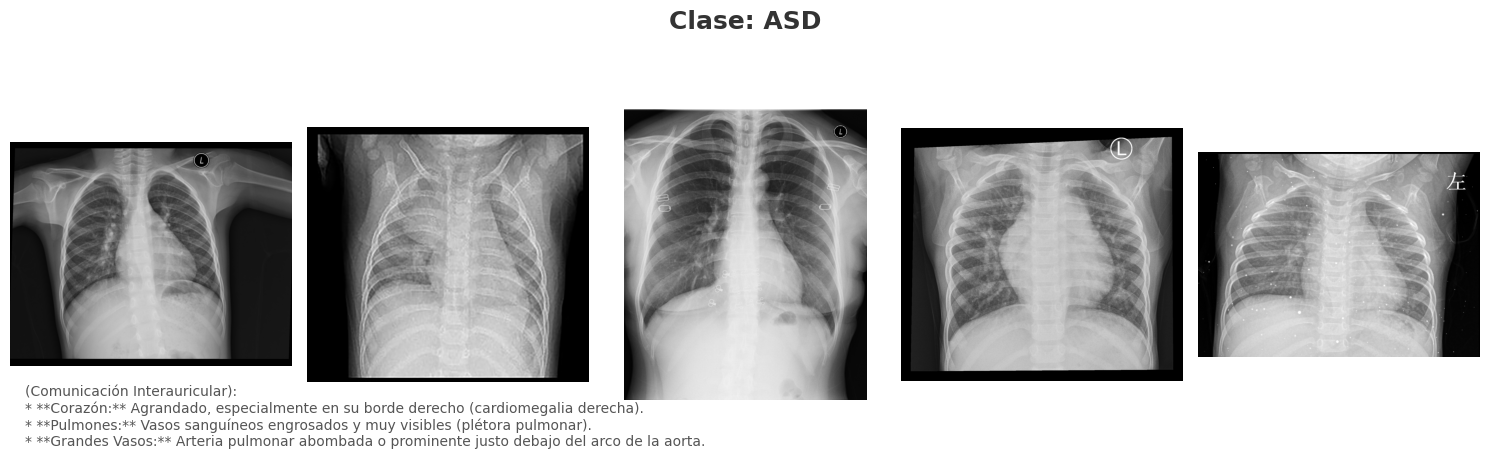

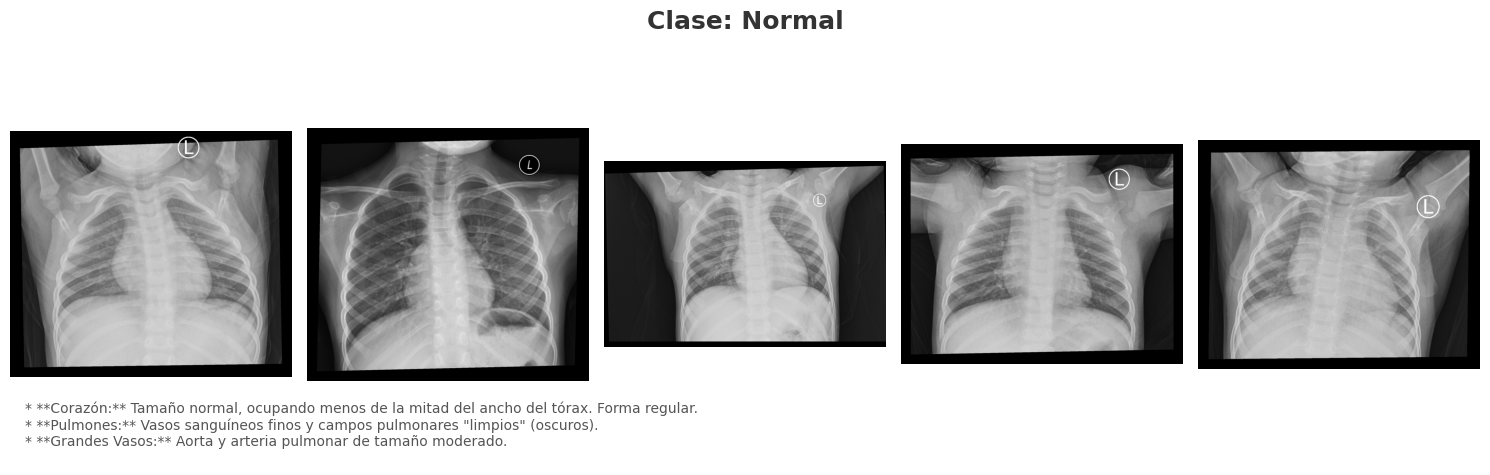

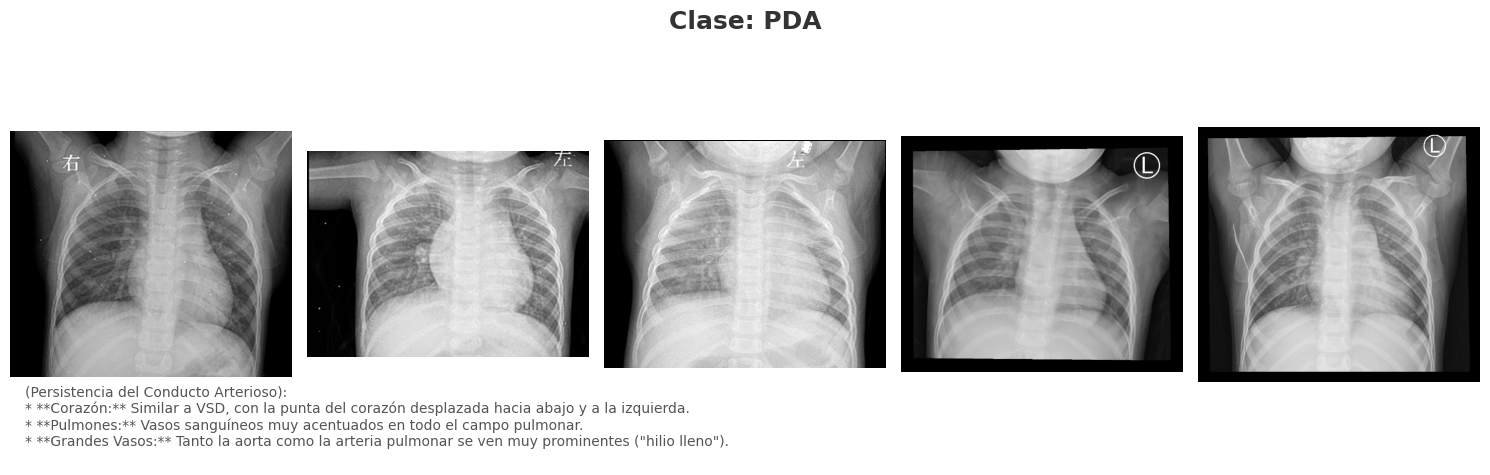

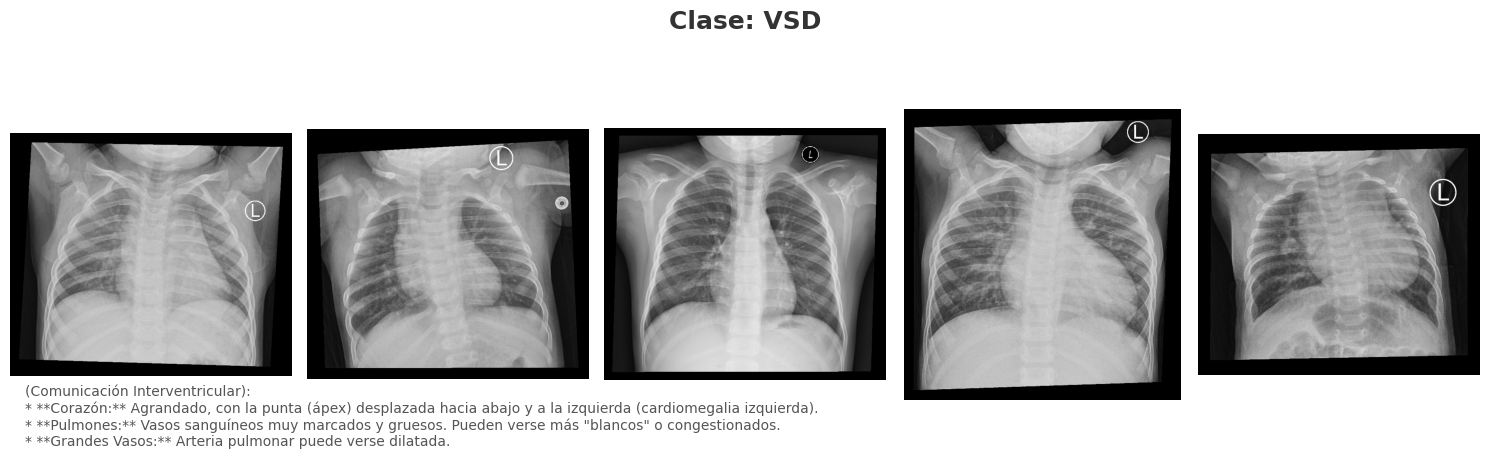

In [ ]:


class_descriptions = {
    "Normal": """
* **Corazón:** Tamaño normal, ocupando menos de la mitad del ancho del tórax. Forma regular.
* **Pulmones:** Vasos sanguíneos finos y campos pulmonares "limpios" (oscuros).
* **Grandes Vasos:** Aorta y arteria pulmonar de tamaño moderado.
""",
    "ASD": """
(Comunicación Interauricular):
* **Corazón:** Agrandado, especialmente en su borde derecho (cardiomegalia derecha).
* **Pulmones:** Vasos sanguíneos engrosados y muy visibles (plétora pulmonar).
* **Grandes Vasos:** Arteria pulmonar abombada o prominente justo debajo del arco de la aorta.
""",
    "VSD": """
(Comunicación Interventricular):
* **Corazón:** Agrandado, con la punta (ápex) desplazada hacia abajo y a la izquierda (cardiomegalia izquierda).
* **Pulmones:** Vasos sanguíneos muy marcados y gruesos. Pueden verse más "blancos" o congestionados.
* **Grandes Vasos:** Arteria pulmonar puede verse dilatada.
""",
    "PDA": """
(Persistencia del Conducto Arterioso):
* **Corazón:** Similar a VSD, con la punta del corazón desplazada hacia abajo y a la izquierda.
* **Pulmones:** Vasos sanguíneos muy acentuados en todo el campo pulmonar.
* **Grandes Vasos:** Tanto la aorta como la arteria pulmonar se ven muy prominentes ("hilio lleno").
"""
}

# Ejemplo de cómo lo usarías en tu bucle
# for class_name in class_names:
#     ...
#     description = xray_observations.get(class_name, "Guía de observación no disponible.")
#     fig.text(0.02, 0.05, description, ...)
#     ...

samples_per_class = 5

for class_name in class_names:
    class_images = df[df['label'] == class_name]['image_path'].head(samples_per_class).tolist()

    if not class_images:
        print(f"No se encontraron imágenes para la clase: {class_name}")
        continue

    fig, axes = plt.subplots(1, samples_per_class, figsize=(15, 4.5))


    fig.suptitle(f'Clase: {class_name}', fontsize=18, fontweight='bold', color='#333333', y=1.05)

    if samples_per_class == 1:
        axes = [axes]

    for i, img_path in enumerate(class_images):
        img = Image.open(img_path).convert("L")
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')

    for i in range(len(class_images), samples_per_class):
        axes[i].axis('off')

    description = class_descriptions.get(class_name, "Descripción no disponible.")


    fig.text(0.02, 0.05, description,
             wrap=True,
             ha='left',
             fontsize=10,
             color='#555555',
             # bbox=box_props # Descomentar para aplicar el estilo de caja
             transform=fig.transFigure)

    plt.tight_layout(rect=[0, 0.15, 1, 0.95])
    plt.show()

# 5. Análisis de calidad

### Histograma de ancho y alto de las imagenes


100%|██████████| 828/828 [05:01<00:00,  2.74it/s]


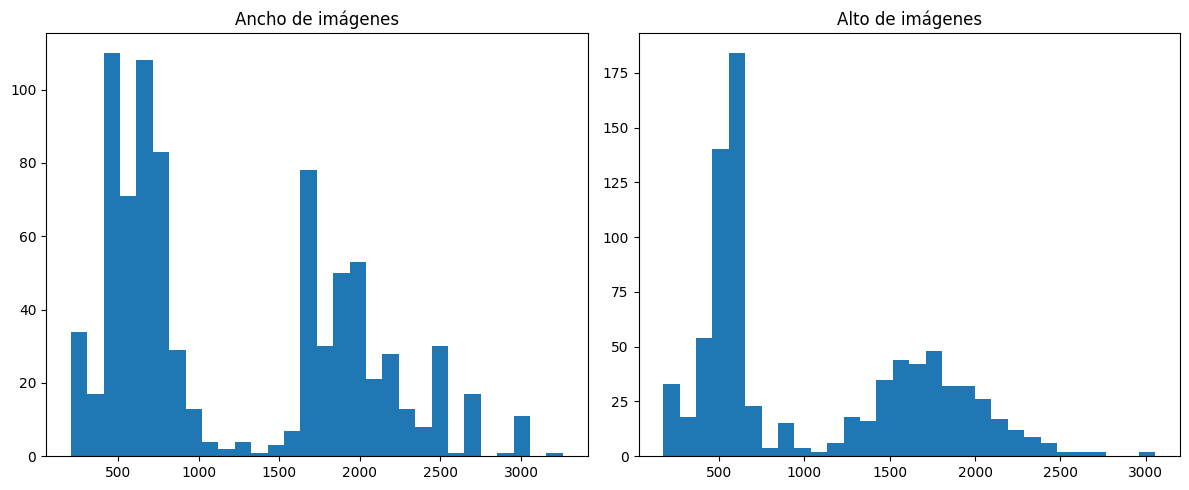

In [ ]:
widths, heights = [], []

for img_path in tqdm(df['image_path']):
    img = Image.open(img_path)
    widths.append(img.width)
    heights.append(img.height)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=30)
plt.title("Ancho de imágenes")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30)
plt.title("Alto de imágenes")

plt.tight_layout()
plt.show()


El análisis de los histogramas para el ancho y alto de las imágenes del dataset revela características clave sobre su resolución:

* Heterogeneidad de Dimensiones: Existe una notable variabilidad en el tamaño de las imágenes, lo que indica que no están estandarizadas a una resolución única.

* Distribución Bimodal: Las dimensiones se agrupan claramente en dos clusters principales:
  * Grupo Mayoritario (Baja Resolución): La concentración más alta de imágenes
presenta dimensiones reducidas, con anchos y altos que se sitúan predominantemente en el rango de 500 a 800 píxeles.

  * Grupo Minoritario (Alta Resolución): Se observa un segundo grupo de imágenes con una resolución significativamente mayor, centradas en el rango de 1,500 a 2,000 píxeles.

### Histograma de relacion de aspectos

100%|██████████| 828/828 [00:02<00:00, 291.30it/s]


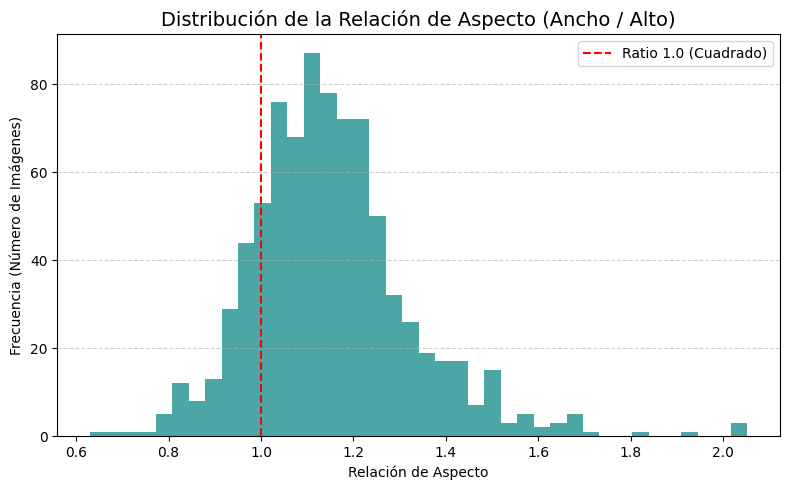

In [ ]:
aspect_ratios = []

for img_path in tqdm(df['image_path']):
    try:
        with Image.open(img_path) as img:
            if img.height > 0:
                ratio = img.width / img.height
                aspect_ratios.append(ratio)
    except Exception as e:
        print(f"No se pudo procesar la imagen {img_path}: {e}")

plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=40, color='teal', alpha=0.7)
plt.title("Distribución de la Relación de Aspecto (Ancho / Alto)", fontsize=14)
plt.xlabel("Relación de Aspecto")
plt.ylabel("Frecuencia (Número de Imágenes)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.axvline(1.0, color='red', linestyle='dashed', linewidth=1.5, label='Ratio 1.0 (Cuadrado)')
plt.legend()

plt.tight_layout()
plt.show()

El histograma que muestra la distribución de la relación de aspecto (calculada como ancho/alto) proporciona información clave sobre la forma predominante de las imágenes en el dataset.

* Tendencia Principal: La mayoría de las imágenes no son perfectamente cuadradas. El pico de la distribución se sitúa ligeramente a la derecha de la línea de referencia de 1.0, específicamente en un ratio aproximado de 1.1 a 1.2. Esto indica que la forma más común es ligeramente rectangular, siendo un 10-20% más ancha que alta (formato apaisado o landscape).

* Concentración de Datos: A pesar de la tendencia apaisada, una gran cantidad de imágenes se agrupa muy cerca del ratio 1.0, lo que significa que una porción significativa del dataset tiene una forma casi cuadrada.

* Asimetría: La distribución presenta una ligera asimetría positiva (cola hacia la derecha), evidenciando la presencia de algunas imágenes atípicas que son considerablemente más anchas que altas.

### Histograma de relacion de intensidades

In [ ]:
# Histograma de intensidades
def get_intensity_stats(image_path):
    try:
        with Image.open(image_path).convert('L') as img:
            img_array = np.array(img)
            return img_array.mean(), img_array.std()
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None, None


stats = df['image_path'].apply(get_intensity_stats)
df[['mean_intensity', 'std_intensity']] = pd.DataFrame(stats.tolist(), index=df.index)



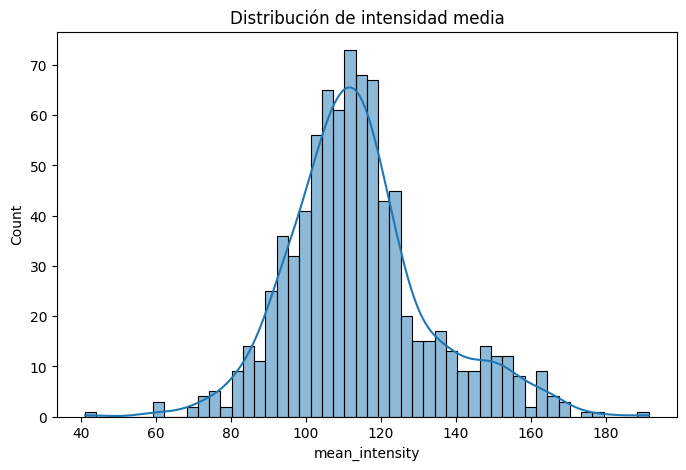

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['mean_intensity'], bins=50, kde=True)
plt.title("Distribución de intensidad media")
plt.show()

Este histograma muestra la distribución del brillo promedio de cada imagen. La intensidad de un píxel en escala de grises va de 0 (negro) a 255 (blanco).

* Distribución Normal y Consistente: La distribución de la intensidad media es unimodal y se aproxima a una curva normal (gaussiana). Esto es un indicador positivo de la calidad del dataset, ya que sugiere que la mayoría de las imágenes fueron capturadas bajo condiciones de exposición similares.

* Exposición Centrada: El pico de la distribución se encuentra alrededor de un valor de intensidad media de 110-115. Este valor, situado en el rango de los grises medios, es característico de radiografías con una exposición bien equilibrada, ni muy oscuras ni muy brillantes.

* Presencia de Outliers: Aunque la mayoría de las imágenes son consistentes, la distribución presenta colas en ambos extremos:

  * Un pequeño número de imágenes tienen una intensidad media baja (< 80), lo que sugiere que podrían estar subexpuestas (demasiado oscuras).

  * Otro grupo minoritario tiene una intensidad media alta (> 140), indicando que podrían estar sobreexpuestas (demasiado brillantes o "quemadas").

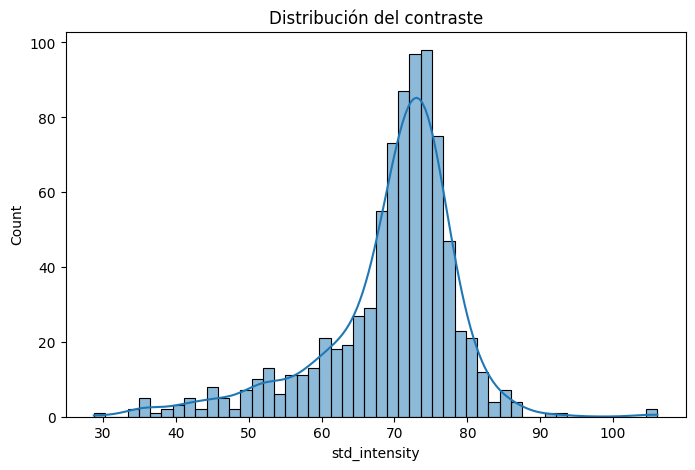

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['std_intensity'], bins=50, kde=True)
plt.title("Distribución del contraste")
plt.show()

Este histograma muestra la distribución del contraste en las imágenes, medido a través de la desviación estándar (std_intensity) de los valores de los píxeles. Un valor más alto indica un mayor contraste.

* Contraste Generalmente Consistente: La distribución es unimodal, con un pico claramente definido en el rango de 70 a 75. Esto indica que la mayoría de las imágenes en el dataset poseen un nivel de contraste saludable y consistente, lo cual es positivo para el análisis visual y computacional.

* Presencia de Imágenes de Bajo Contraste: El hallazgo más relevante es la asimetría negativa (cola hacia la izquierda) de la distribución. Esto revela la existencia de un número significativo de imágenes con una desviación estándar inferior a 60, lo que se traduce en un bajo contraste. Estas imágenes pueden aparecer "planas" o "lavadas", dificultando la distinción de detalles finos en las estructuras anatómicas.

* Outliers de Alto Contraste: Se observa un pequeño grupo aislado de imágenes con un contraste extremadamente alto (valores > 100), que podrían ser consideradas atípicas.

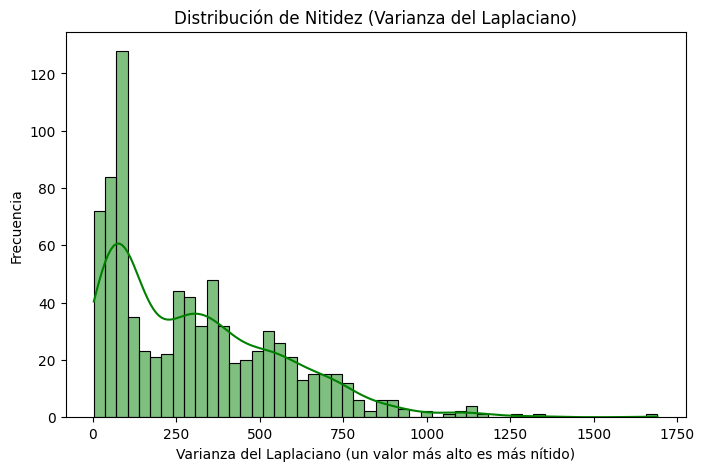

In [ ]:
import cv2

def get_blurriness_score(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        return laplacian_var
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

# Aplicamos la función y creamos la nueva columna
df['laplacian_variance'] = df['image_path'].apply(get_blurriness_score)

plt.figure(figsize=(8, 5))
sns.histplot(df['laplacian_variance'].dropna(), bins=50, kde=True, color='green')
plt.title("Distribución de Nitidez (Varianza del Laplaciano)")
plt.xlabel("Varianza del Laplaciano (un valor más alto es más nítido)")
plt.ylabel("Frecuencia")
plt.show()


Este histograma evalúa la nitidez de las imágenes mediante la Varianza del Laplaciano, una métrica donde valores más altos corresponden a imágenes más nítidas y enfocadas.

* Distribución Asimétrica: La distribución está fuertemente sesgada hacia la derecha (asimetría positiva). Esto significa que la gran mayoría de las imágenes se concentran en los valores más bajos de la métrica, mientras que un número menor de imágenes alcanza puntuaciones de nitidez altas.

* Alta Frecuencia de Imágenes Poco Nítidas: El hallazgo más significativo es el pico de alta frecuencia en el rango bajo de la varianza (aproximadamente entre 50 y 150). Esto indica que una porción considerable del dataset está compuesta por imágenes con baja nitidez, lo que sugiere que podrían estar borrosas o desenfocadas. (Comun en rayos x por la superposición de capas)

* Existencia de Imágenes Nítidas: La "cola" larga de la distribución que se extiende hacia valores más altos demuestra que también existe un buen número de imágenes con niveles de nitidez adecuados o excelentes, aunque son menos frecuentes.

# 6. Detección de duplicados

Se encontraron 8 imágenes duplicadas o muy similares.
                                            image_path   label  \
5    /content/drive/MyDrive/CARDIOS - PROYECTO INTE...     ASD   
33   /content/drive/MyDrive/CARDIOS - PROYECTO INTE...     ASD   
267  /content/drive/MyDrive/CARDIOS - PROYECTO INTE...  Normal   
272  /content/drive/MyDrive/CARDIOS - PROYECTO INTE...  Normal   
139  /content/drive/MyDrive/CARDIOS - PROYECTO INTE...     ASD   
161  /content/drive/MyDrive/CARDIOS - PROYECTO INTE...     ASD   
739  /content/drive/MyDrive/CARDIOS - PROYECTO INTE...     VSD   
800  /content/drive/MyDrive/CARDIOS - PROYECTO INTE...     VSD   

     mean_intensity  std_intensity  laplacian_variance        image_hash  
5        110.642944      74.915700          339.129063  91386e1a3b5769c6  
33       110.642944      74.915700          339.129063  91386e1a3b5769c6  
267      120.804277      70.429930          117.444416  9179171f1b1d3991  
272      120.804277      70.429930          117.444

/tmp/ipython-input-4189656822.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates['image_hash_str'] = duplicates['image_hash'].astype(str)


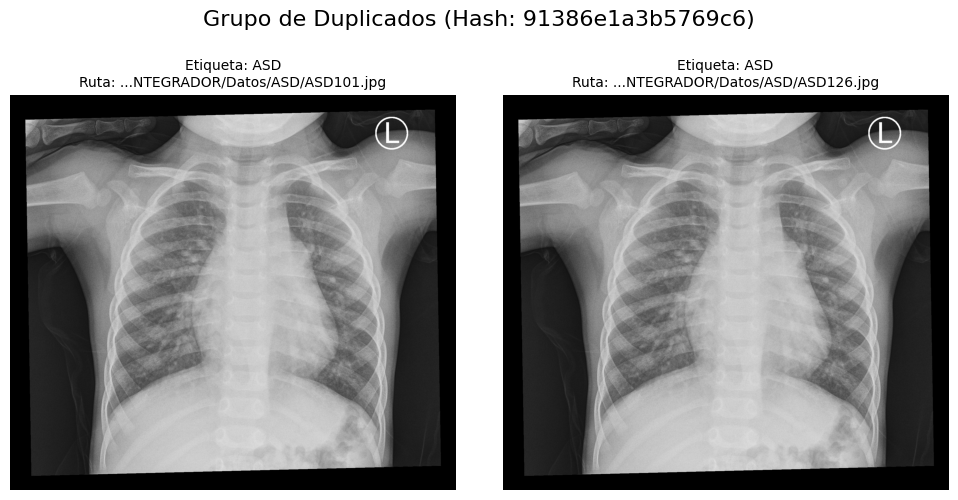

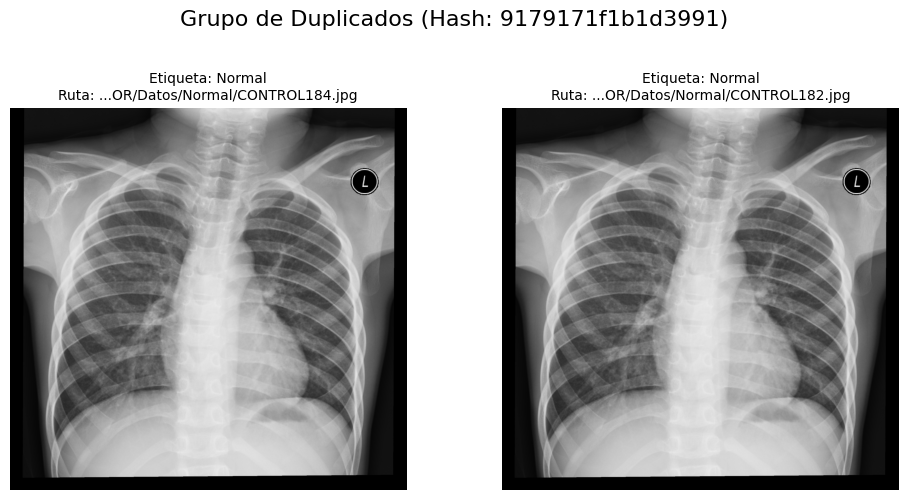

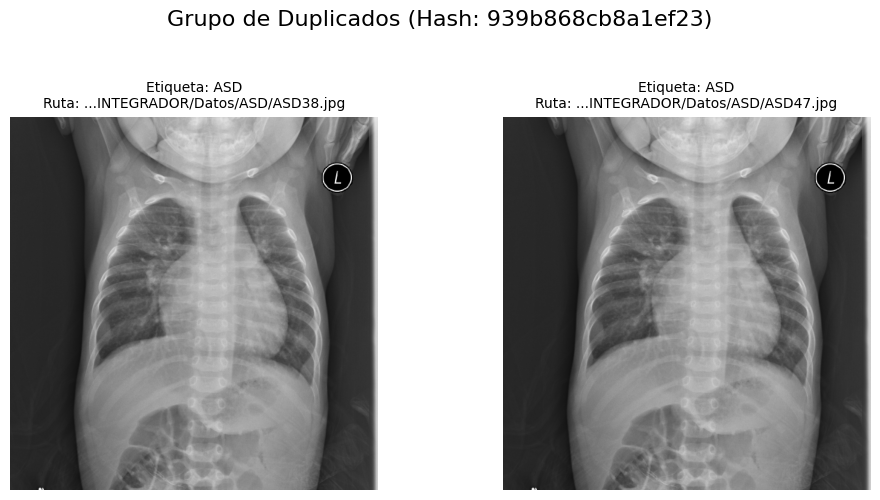

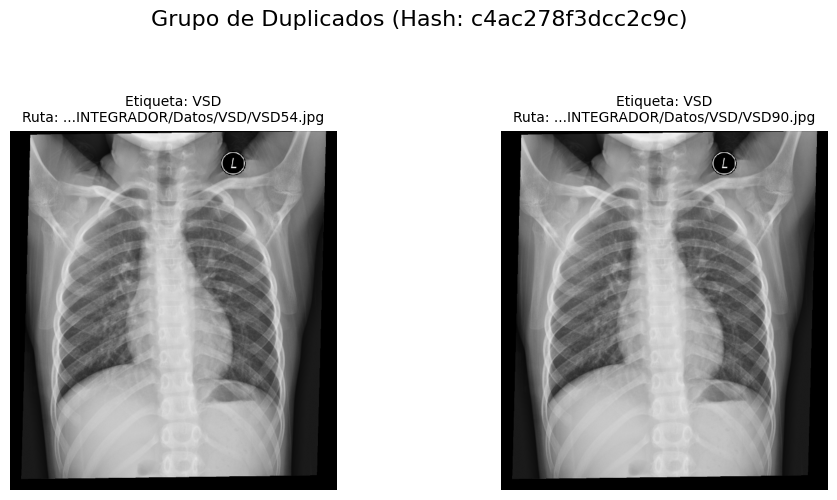

In [ ]:
def get_image_hash(image_path):
    try:
        with Image.open(image_path) as img:
            return imagehash.phash(img)
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

# Calculamos el hash para cada imagen
df['image_hash'] = df['image_path'].apply(get_image_hash)

# Buscamos duplicados
duplicates = df[df.duplicated(subset=['image_hash'], keep=False)]

if not duplicates.empty:
    print(f"Se encontraron {len(duplicates)} imágenes duplicadas o muy similares.")
    print(duplicates.sort_values(by='image_hash', key=lambda col: col.astype(str)).head(10))
    duplicates['image_hash_str'] = duplicates['image_hash'].astype(str)

    grouped_duplicates = duplicates.groupby('image_hash_str')

    for hash_value, group in grouped_duplicates:
      num_duplicates = len(group)
      fig, axes = plt.subplots(1, num_duplicates, figsize=(5 * num_duplicates, 5))

      fig.suptitle(f"Grupo de Duplicados (Hash: {hash_value})", fontsize=16, y=1.02)

      if num_duplicates == 1:
          axes = [axes]

      for i, (index, row) in enumerate(group.iterrows()):
          img_path = row['image_path']
          label = row['label']

          try:
              img = Image.open(img_path)
              axes[i].imshow(img, cmap='gray')

              axes[i].set_title(f"Etiqueta: {label}\nRuta: ...{img_path[-30:]}", fontsize=10)
              axes[i].axis('off')
          except FileNotFoundError:
              axes[i].set_title(f"ERROR: Archivo no encontrado\n{img_path}", fontsize=10)
              axes[i].axis('off')

      plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustamos el layout para que el título no se superponga
      plt.show()
else:
    print("No se encontraron imágenes duplicadas.")

In [ ]:
import hashlib

def get_image_hash(img_path):
    with open(img_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['hash'] = df['image_path'].apply(get_image_hash)
duplicates = df[df.duplicated('hash', keep=False)]

print(f"Se encontraron {len(duplicates)} imágenes duplicadas.")
duplicates.head()


# 7. Extracción de embeddings y t-SNE

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]
100%|██████████| 300/300 [02:16<00:00,  2.20it/s]


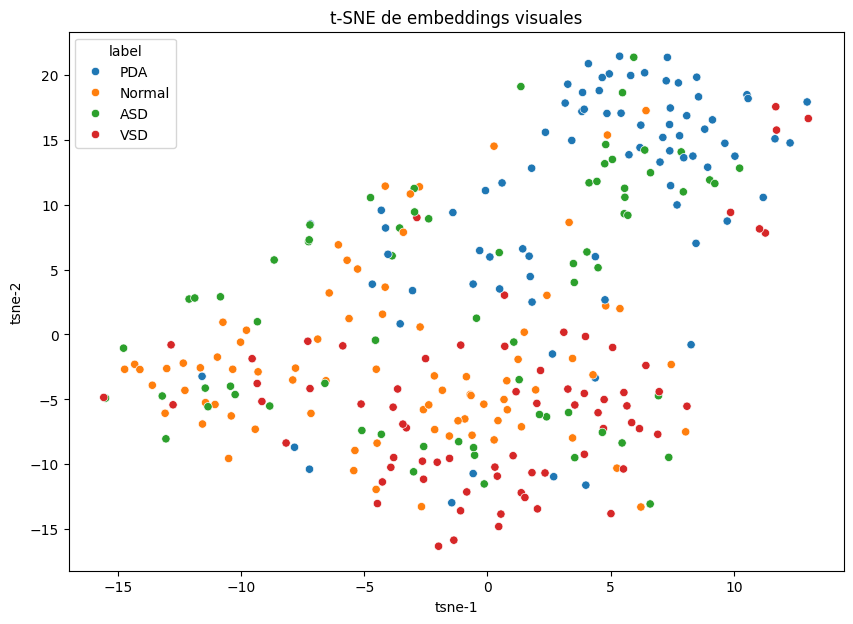

In [5]:
# Usar modelo preentrenado (ej. ResNet18)
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def extract_embedding(image_path):
    img = Image.open(image_path).convert('RGB')
    img_t = transform(img).unsqueeze(0)
    with torch.no_grad():
        embedding = model(img_t)
    return embedding.view(-1).numpy()

# Aplicar a una muestra
df_sample = df.sample(300, random_state=42).reset_index(drop=True)
embeddings = np.array([extract_embedding(p) for p in tqdm(df_sample['image_path'])])

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

df_sample['tsne-1'] = tsne_result[:,0]
df_sample['tsne-2'] = tsne_result[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(x='tsne-1', y='tsne-2', hue='label', data=df_sample, palette='tab10')
plt.title("t-SNE de embeddings visuales")
plt.show()


El gráfico presentado corresponde a una proyección bidimensional mediante t-SNE aplicada a los embeddings visuales derivados de un conjunto de radiografías, en el que se representan cuatro clases clínicas: Normal, PDA (ductus arterioso persistente), ASD (defecto septal auricular) y VSD (defecto septal ventricular). Cada punto en la visualización representa una imagen codificada en un espacio latente, y su disposición refleja similitudes estructurales en los patrones visuales extraídos por el modelo.

Como interpretación se puede decir que si bien existe un grado de agrupamiento distinguible —particularmente en el caso de PDA y en menor medida ASD, también se observa un solapamiento considerable entre clases, especialmente entre VSD y Normal. Este comportamiento indica que los embeddings capturan señales discriminativas relevantes, pero aún presentan zonas de confusión que limitan la separación nítida entre categorías. En consecuencia, la visualización sugiere que, para mejorar la capacidad clasificatoria, será necesario refinar el modelo, ampliar la cantidad de datos disponibles o incorporar técnicas adicionales de procesamiento que fortalezcan la diferenciación entre patologías con manifestaciones visuales similares.

# Conclusión
El análisis exploratorio realizado evidencia que, en un proyecto basado en imágenes, la caracterización visual del dataset es fundamental para anticipar los retos que enfrentará el modelo en términos de normalización, balance de clases y representatividad. La variabilidad en dimensiones, relaciones de aspecto e intensidades muestra la necesidad de aplicar técnicas de preprocesamiento como escalado, recorte o ajuste de contraste para homogeneizar las entradas al modelo. Asimismo, la identificación de distribuciones desbalanceadas entre clases subraya la importancia de considerar estrategias de aumento de datos o técnicas de muestreo. En conjunto, este EDA permitió obtener un panorama integral de la calidad y diversidad del dataset de radiografías, lo que constituye un paso esencial para asegurar la solidez metodológica y la validez de los resultados en etapas posteriores de entrenamiento y validación de modelos de visión computacional.

# Referencias



*   Rausch, D. (2021, 11 de abril). EDA for Image Classification [Artículo]. Geek Culture (Medium). https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
*   Li, M., Jiang, Y., Zhang, Y., & Zhu, H. (2023, 7 de noviembre). Medical image analysis using deep learning algorithms. Frontiers in Public Health, 11, 1273253. https://doi.org/10.3389/fpubh.2023.1273253
* Ray. (2022, 29 de enero). Computer Vision: Exploring your image datasets the RIGHT way. Medium. https://raychunyin00.medium.com/computer-vision-exploring-your-image-datasets-the-right-way-538c5ae8ca5d
* Costa, R. (2022). The CRISP-ML Methodology: A Step-by-Step Approach to Real-World Machine Learning Projects. Edición propia.


